In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d
from scipy import linalg
from torchvision.utils import save_image
import os

# WGAN Hyperparameters
wgan_batch_size = 128
wgan_lr = 0.0002
wgan_latent_dim = 100
wgan_n_epochs = 50
wgan_n_critic = 3
wgan_gradient_penalty = 10
wgan_beta1 = 0.5
wgan_beta2 = 0.999

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Beginning Training Process...")

Using device: cuda
Beginning Training Process...


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(wgan_latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512, momentum=0.9),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 2, 0),
        )

    def forward(self, x):
        return self.disc(x)

In [4]:
class WGANFeatureExtractor(nn.Module):
    DEFAULT_BLOCK_IDX = 3
    FEATURE_DIMS = {64: 0, 192: 1, 768: 2, 2048: 3}

    def __init__(self, output_blocks=[DEFAULT_BLOCK_IDX], resize_input=True,
                 normalize_input=True, requires_grad=False):
        super(WGANFeatureExtractor, self).__init__()
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_block = max(output_blocks)
        
        assert self.last_block <= 3, 'Last possible output block index is 3'
        
        inception = models.inception_v3(pretrained=True)
        self.blocks = nn.ModuleList()

        # Block 0: Initial processing
        initial_block = [inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3, 
                      inception.Conv2d_2b_3x3, nn.MaxPool2d(kernel_size=3, stride=2)]
        self.blocks.append(nn.Sequential(*initial_block))

        # Block 1: Early features
        if self.last_block >= 1:
            early_block = [inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3,
                        nn.MaxPool2d(kernel_size=3, stride=2)]
            self.blocks.append(nn.Sequential(*early_block))

        # Block 2: Mid-level features
        if self.last_block >= 2:
            mid_block = [inception.Mixed_5b, inception.Mixed_5c, inception.Mixed_5d,
                      inception.Mixed_6a, inception.Mixed_6b, inception.Mixed_6c,
                      inception.Mixed_6d, inception.Mixed_6e]
            self.blocks.append(nn.Sequential(*mid_block))

        # Block 3: Final features
        if self.last_block >= 3:
            final_block = [inception.Mixed_7a, inception.Mixed_7b, inception.Mixed_7c,
                        nn.AdaptiveAvgPool2d(output_size=(1, 1))]
            self.blocks.append(nn.Sequential(*final_block))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, x):
        block_outputs = []
        current_input = x

        if self.resize_input:
            current_input = F.interpolate(current_input, size=(299, 299), 
                                        mode='bilinear', align_corners=False)
        if self.normalize_input:
            current_input = 2 * current_input - 1

        for idx, block in enumerate(self.blocks):
            current_input = block(current_input)
            if idx in self.output_blocks:
                block_outputs.append(current_input)
            if idx == self.last_block:
                break

        return block_outputs

def compute_wgan_feature_statistics(images, extractor, batch_size=128, dims=2048, cuda=False):
    extractor.eval()
    feature_activations = np.empty((len(images), dims))
    
    if cuda:
        batch = images.cuda()
    else:
        batch = images
    features = extractor(batch)[0]
    
    if features.size(2) != 1 or features.size(3) != 1:
        features = adaptive_avg_pool2d(features, output_size=(1, 1))
    
    feature_activations = features.cpu().data.numpy().reshape(features.size(0), -1)
    mu = np.mean(feature_activations, axis=0)
    sigma = np.cov(feature_activations, rowvar=False)
    return mu, sigma

def compute_wgan_fid(mu1, sigma1, mu2, sigma2, epsilon=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2
    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * epsilon
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    trace_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * trace_covmean

def calculate_wgan_score(real_images, generated_images, feature_extractor):
    mu_real, sigma_real = compute_wgan_feature_statistics(real_images, feature_extractor, cuda=True)
    mu_fake, sigma_fake = compute_wgan_feature_statistics(generated_images, feature_extractor, cuda=True)
    fid_value = compute_wgan_fid(mu_real, sigma_real, mu_fake, sigma_fake)
    return fid_value

def compute_wgan_gradient_penalty(discriminator, real_samples, fake_samples, device):
    batch_size, channels, height, width = real_samples.shape
    epsilon = torch.rand((batch_size, 1, 1, 1)).repeat(1, channels, height, width).to(device)
    interpolated_images = real_samples * epsilon + fake_samples * (1 - epsilon)
    
    mixed_scores = discriminator(interpolated_images)
    
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    
    return penalty

In [5]:
def load_wgan_dataset():
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    cifar_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    wgan_loader = DataLoader(
        cifar_dataset,
        batch_size=wgan_batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True
    )
    return wgan_loader

In [6]:
def save_wgan_training_metrics(epoch, disc_loss, gen_loss, accuracy, fid, log_file):
    with open(log_file, 'a') as f:
        f.write(f"Epoch {epoch}: Discriminator_Loss={disc_loss:.4f}, Generator_Loss={gen_loss:.4f}, "
                f"Accuracy={accuracy*100:.2f}%, Quality={fid:.4f}\n")

def save_wgan_comparison(real_imgs, fake_imgs, epoch_num):
    plt.figure(figsize=(20, 10))
    
    # Real Images
    plt.subplot(1, 2, 1)
    real_grid = torchvision.utils.make_grid(real_imgs, nrow=8, normalize=True)
    plt.imshow(real_grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title('Real Images')
    
    # Generated Images
    plt.subplot(1, 2, 2)
    fake_grid = torchvision.utils.make_grid(fake_imgs, nrow=8, normalize=True)
    plt.imshow(fake_grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title('Generated Images')
    
    # Save grids
    torchvision.utils.save_image(real_grid, f"WGAN_results/RealImages/real_epoch_{epoch_num}.png")
    torchvision.utils.save_image(fake_grid, f"WGAN_results/GeneratedImages/generated_epoch_{epoch_num}.png")
    plt.savefig(f"WGAN_results/CompareImages/comparison_epoch_{epoch_num}.png", bbox_inches='tight')
    plt.close()

def calculate_wgan_accuracy(real_preds, fake_preds):
    real_accuracy = (real_preds > 0).float().mean().item()
    fake_accuracy = (fake_preds < 0).float().mean().item()
    return (real_accuracy + fake_accuracy) / 2

def train_wgan():
    # Create directories
    os.makedirs("WGAN_results/RealImages", exist_ok=True)
    os.makedirs("WGAN_results/GeneratedImages", exist_ok=True)
    os.makedirs("WGAN_results/CompareImages", exist_ok=True)
    metrics_log = "WGAN_results/wgan_training_metrics.txt"
    
    # Initialize models
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    feature_extractor_idx = WGANFeatureExtractor.FEATURE_DIMS[2048]
    feature_extractor = WGANFeatureExtractor([feature_extractor_idx]).to(device)
    
    # Optimizers
    gen_optimizer = optim.Adam(generator.parameters(), lr=wgan_lr, betas=(wgan_beta1, wgan_beta2))
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=wgan_lr, betas=(wgan_beta1, wgan_beta2))
    
    # Load data
    train_loader = load_wgan_dataset()
    
    # Training metrics
    gen_losses, disc_losses = [], []
    disc_accuracies, fid_scores = [], []
    final_real_batch = None
    final_fake_batch = None
    
    # Training loop
    for epoch in range(wgan_n_epochs):
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        epoch_accuracy = 0
        n_batches = len(train_loader)
        
        for batch_idx, (real_batch, _) in enumerate(train_loader):
            real_batch = real_batch.to(device)
            current_batch_size = real_batch.size(0)
            
            # Train Discriminator
            for _ in range(wgan_n_critic):
                noise = torch.randn(current_batch_size, wgan_latent_dim, 1, 1).to(device)
                fake_batch = generator(noise)
                disc_real = discriminator(real_batch).reshape(-1)
                disc_fake = discriminator(fake_batch).reshape(-1)
                
                batch_accuracy = calculate_wgan_accuracy(disc_real, disc_fake)
                epoch_accuracy += batch_accuracy
                
                gp = compute_wgan_gradient_penalty(discriminator, real_batch, fake_batch, device)
                # WGAN Discriminator (Critic) loss
                disc_loss = (-(torch.mean(disc_real) - torch.mean(disc_fake)) + wgan_gradient_penalty * gp)
                
                disc_optimizer.zero_grad()
                disc_loss.backward(retain_graph=True)
                disc_optimizer.step()

            # Train Generator
            gen_output = discriminator(fake_batch).reshape(-1)
            # WGAN Generator loss
            gen_loss = -torch.mean(gen_output)
            
            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()
            
            epoch_disc_loss += disc_loss.item()
            epoch_gen_loss += gen_loss.item()
            
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch}/{wgan_n_epochs}] Batch [{batch_idx}/{n_batches}] "
                      f"Discriminator_Loss: {disc_loss:.4f} Generator_Loss: {gen_loss:.4f} "
                      f"Accuracy: {batch_accuracy*100:.2f}%")
        
        # Compute epoch metrics
        avg_disc_loss = epoch_disc_loss / n_batches
        avg_gen_loss = epoch_gen_loss / n_batches
        avg_accuracy = epoch_accuracy / n_batches
        
        # Calculate FID
        with torch.no_grad():
            eval_noise = torch.randn(100, wgan_latent_dim, 1, 1).to(device)
            fake_samples = generator(eval_noise)
            fid = calculate_wgan_score(real_batch[:100], fake_samples, feature_extractor)
            fid_scores.append(fid)
        
        print(f"\nEpoch {epoch}: Discriminator_Loss={avg_disc_loss:.4f}, Generator_Loss={avg_gen_loss:.4f}, "
              f"Accuracy={avg_accuracy*100:.2f}%, Quality={fid:.4f}")
        
        # Save metrics
        save_wgan_training_metrics(epoch, avg_disc_loss, avg_gen_loss, 
                                 avg_accuracy, fid, metrics_log)
        
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)
        disc_accuracies.append(avg_accuracy)
        
        # Save image comparisons
        with torch.no_grad():
            fixed_noise = torch.randn(64, wgan_latent_dim, 1, 1).to(device)
            fake_samples = generator(fixed_noise)
            save_wgan_comparison(real_batch[:64], fake_samples, epoch)
        
        if epoch == wgan_n_epochs - 1:
            final_real_batch = real_batch[:64]
            final_fake_batch = fake_samples
    
    # Show final result
    plt.figure(figsize=(20, 10))
    final_real_grid = torchvision.utils.make_grid(final_real_batch, nrow=8, normalize=True)
    final_fake_grid = torchvision.utils.make_grid(final_fake_batch, nrow=8, normalize=True)
    
    plt.subplot(1, 2, 1)
    plt.imshow(final_real_grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title('Real Images - Final Epoch')
    
    plt.subplot(1, 2, 2)
    plt.imshow(final_fake_grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title('Generated Images - Final Epoch')
    plt.show()
    
    return generator, discriminator, {
        'gen_losses': gen_losses,
        'disc_losses': disc_losses,
        'disc_accuracies': disc_accuracies,
        'fid_scores': fid_scores
    }

/home/pchouda/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pchouda/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|██████████| 170498071/170498071 [00:02<00:00, 59136922.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch [0/50] Batch [0/390] Discriminator_Loss: -0.5511 Generator_Loss: 3.3047 Accuracy: 94.53%
Epoch [0/50] Batch [100/390] Discriminator_Loss: -21.0266 Generator_Loss: 28.1230 Accuracy: 70.70%
Epoch [0/50] Batch [200/390] Discriminator_Loss: -14.7446 Generator_Loss: 22.5241 Accuracy: 71.09%
Epoch [0/50] Batch [300/390] Discriminator_Loss: -11.3166 Generator_Loss: 15.2347 Accuracy: 67.58%

Epoch 0: Discriminator_Loss=-16.1201, Generator_Loss=21.5519, Accuracy=213.76%, Quality=367.7482
Epoch [1/50] Batch [0/390] Discriminator_Loss: -11.1118 Generator_Loss: 16.9217 Accuracy: 62.50%
Epoch [1/50] Batch [100/390] Discriminator_Loss: -12.2488 Generator_Loss: 11.1977 Accuracy: 77.73%
Epoch [1/50] Batch [200/390] Discriminator_Loss: -10.1729 Generator_Loss: 18.1611 Accuracy: 64.45%
Epoch [1/50] Batch [300/390] Discriminator_Loss: -9.0891 Generator_Loss: 21.7826 Accuracy: 53.52%

Epoch 1: Discriminator_Loss=-10.4152, Generator_Loss=17.6009, Acc

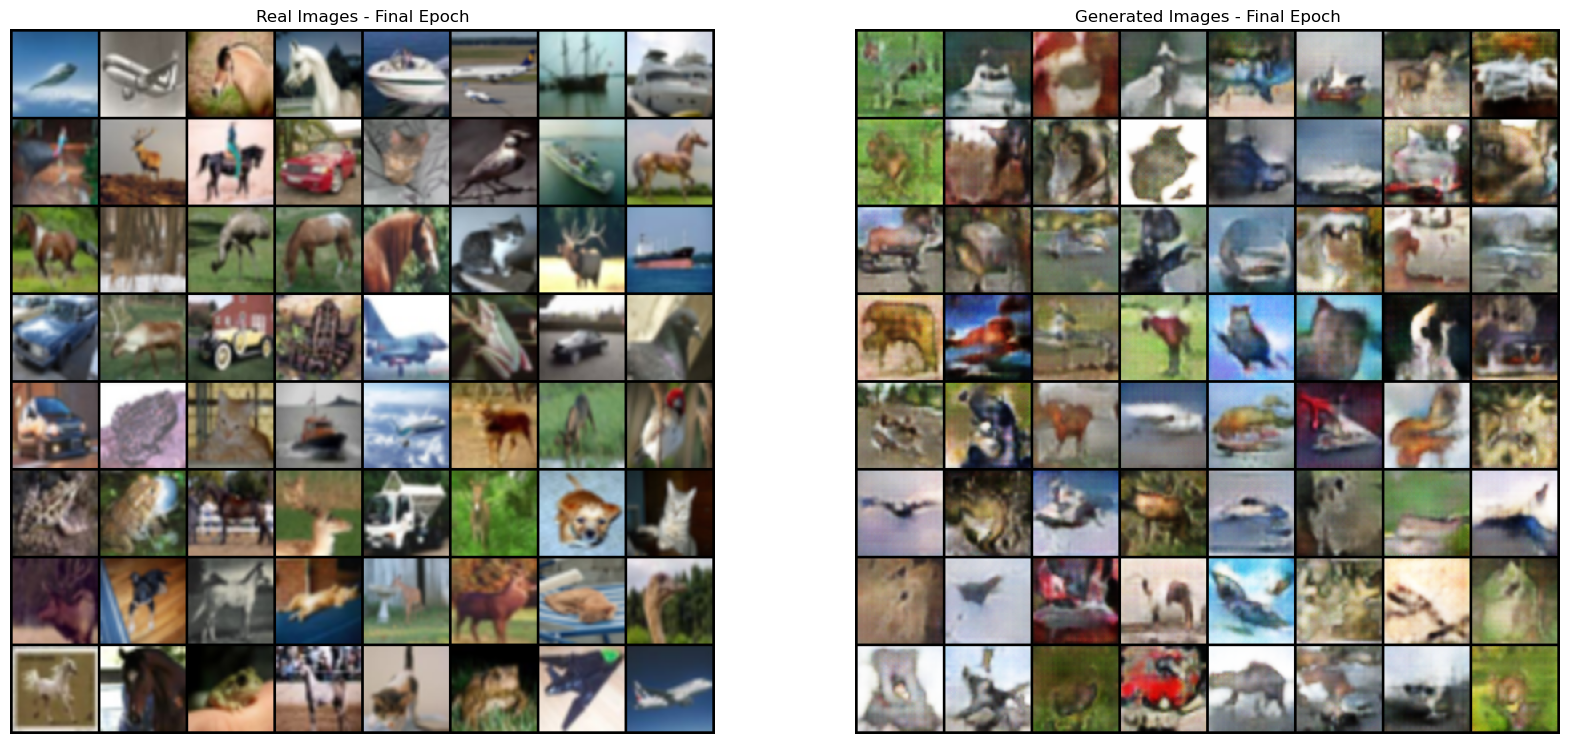

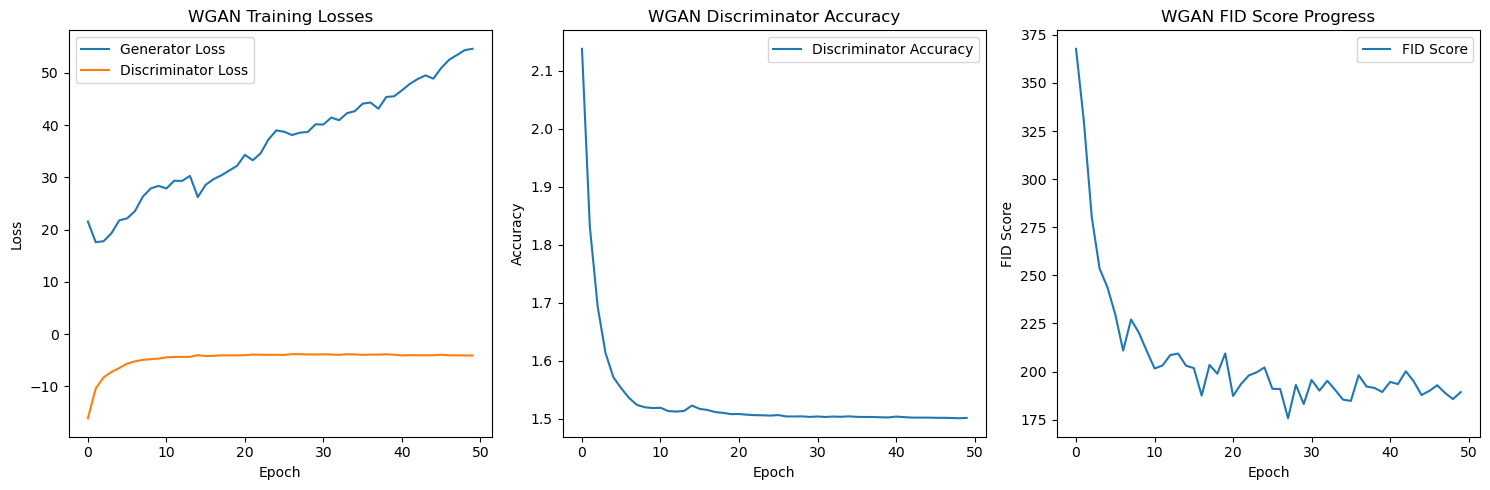

In [7]:
# Train WGAN
trained_generator, trained_discriminator, training_metrics = train_wgan()

# Visualization
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(training_metrics['gen_losses'], label='Generator Loss')
plt.plot(training_metrics['disc_losses'], label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('WGAN Training Losses')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(training_metrics['disc_accuracies'], label='Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('WGAN Discriminator Accuracy')
plt.legend()

# FID Score Plot
plt.subplot(1, 3, 3)
plt.plot(training_metrics['fid_scores'], label='FID Score')
plt.xlabel('Epoch')
plt.ylabel('FID Score')
plt.title('WGAN FID Score Progress')
plt.legend()

plt.tight_layout()
plt.show()